In [2]:
import pandas as pd
import numpy as np 
import sqlite3
import nltk
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import scipy as sp
import sqlite3
import re
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from scipy import stats

%matplotlib inline

In [5]:
conn = sqlite3.connect("/Users/jackmackle/py_work/uranium-twitter-bot/notebooks/june-check-in/storage.db")
df = pd.read_sql_query("SELECT * FROM tweets", conn)
conn.close()

In [6]:
sid = SentimentIntensityAnalyzer()

tw_text_list = df["full_text"].tolist()
polarity_scores = list(map(sid.polarity_scores, tw_text_list))
compound = list(map(lambda x: x["compound"], polarity_scores))

df["compound_pol"] = compound

In [7]:
strip_date = list(map(lambda x: x.split()[0], df["created_at"].to_list()))
df["stripdate"] = strip_date
df_date_group = df[["stripdate", "compound_pol"]].groupby("stripdate", as_index=False).agg(['count','mean']).reset_index()

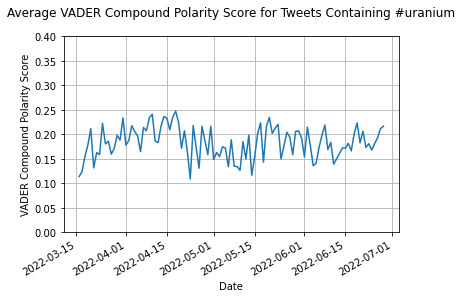

In [28]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(df_date_group["stripdate"].astype('datetime64[ns]'),
         df_date_group["compound_pol"]["mean"],
         label="Compound Polarity Score")
    
ax1.set_title("Average VADER Compound Polarity Score for Tweets Containing #uranium",
              pad=20)
ax1.set_ylabel("VADER Compound Polarity Score")
ax1.set_xlabel("Date")
ax1.set_ylim([0,.4])

#date_form = DateFormatter("%M")
#ax1.xaxis.set_major_formatter(date_form)

#datemin = datetime.date(df_date_group["stripdate"].astype('datetime64[ns]').min())
#datemax = datetime.date(df_date_group["stripdate"].astype('datetime64[ns]').max())
#ax1.set_xlim(datemin, datemax)

ax1.format_xdata = mdates.DateFormatter('%M')
ax1.grid(True)
fig.autofmt_xdate()

plt.show()


In [48]:
list_compol = list(df_date_group["compound_pol"]["mean"])

changes = []

for idx, i in enumerate(list_compol):
    if idx == 0:
        change = 0
    else:
        change = (i/list_compol[idx - 1]) * 100
        change = change - 100
        change = round(change, 2)
        
    changes.append(change)

df_date_group["change"] = changes
df_date_group["Date"] = df_date_group["stripdate"].astype('datetime64[ns]')
df_date_group

stripdate compound_pol           change       date       Date
                       count      mean                             
0    2022-03-16          472  0.113467   0.00 2022-03-16 2022-03-16
1    2022-03-17          633  0.123583   8.91 2022-03-17 2022-03-17
2    2022-03-18          493  0.154629  25.12 2022-03-18 2022-03-18
3    2022-03-19          319  0.177824  15.00 2022-03-19 2022-03-19
4    2022-03-20          278  0.211335  18.84 2022-03-20 2022-03-20
..          ...          ...       ...    ...        ...        ...
100  2022-06-24          401  0.167657  -7.23 2022-06-24 2022-06-24
101  2022-06-25          196  0.180764   7.82 2022-06-25 2022-06-25
102  2022-06-26          193  0.192717   6.61 2022-06-26 2022-06-26
103  2022-06-27          340  0.211458   9.72 2022-06-27 2022-06-27
104  2022-06-28           30  0.216413   2.34 2022-06-28 2022-06-28

[105 rows x 6 columns]

In [51]:
urnm = pd.read_csv("/Users/jackmackle/py_work/uranium-twitter-bot/notebooks/june-check-in/urnm.txt",
                   sep = "\t")

strip_date = list(map(lambda x: x.split()[0], urnm["Date"].to_list()))
urnm["Date"] = strip_date
urnm["Date"] = urnm["Date"].astype('datetime64[ns]')


In [53]:
joined = pd.merge(urnm, df_date_group, on="Date", how="left")
joined

,Date,Close,percent_change,"(stripdate, )","(compound_pol, count)","(compound_pol, mean)","(change, )","(date, )"
0,2022-03-16,75.55,0.00,2022-03-16,472,0.113467,0.00,2022-03-16
1,2022-03-17,81.94,8.46,2022-03-17,633,0.123583,8.91,2022-03-17
2,2022-03-18,82.18,0.29,2022-03-18,493,0.154629,25.12,2022-03-18
3,2022-03-21,85.07,3.52,2022-03-21,579,0.131362,-37.84,2022-03-21
4,2022-03-22,86.24,1.38,2022-03-22,492,0.162497,23.70,2022-03-22
...,...,...,...,...,...,...,...,...
66,2022-06-21,59.76,3.30,2022-06-21,280,0.206181,13.10,2022-06-21
67,2022-06-22,56.92,-4.75,2022-06-22,273,0.173089,-16.05,2022-06-22
68,2022-06-23,56.03,-1.56,2022-06-23,332,0.180729,4.41,2022-06-23
69,2022-06-24,60.26,7.55,2022-06-24,401,0.167657,-7.23,2022-06-24


In [69]:
joined.columns
joined.columns = ["Date", 
                  "Close", 
                  "urnm_change", 
                  "stripdate", 
                  "tweet_count",
                  "avg_com_pol",
                  "acp_change",
                  "date"]

corr, p = pearsonr(joined["urnm_change"], joined["acp_change"])


